## Workspace setup. Libraries loading

In [2]:
import glob

import tensorflow as tf
import tensorflow_probability as tfp
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#import tensorflow_docs.modeling

import os
import time
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from functools import partial
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32')

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

workerEnv = str(os.getenv("USER"))
workOnPrometheus = workerEnv.find("plg")>-1
inputDataPrefix = "/home/user1/scratch_ssd/akalinow/"
if workOnPrometheus:
    inputDataPrefix = "/net/people/plgakalinow/plggcmsml/"

trainDataDir = inputDataPrefix+"/ProgrammingProjects/MachineLearning/TauTauMass/data/15_09_2020/"   
testDataDir = inputDataPrefix+"/ProgrammingProjects/MachineLearning/TauTauMass/data/29_06_2020/" 

massBins = tf.concat((tf.range(0.0, 300, 5, dtype=tf.float32), [300,9999.0]), axis=0)

## Start Tensorboard server

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit --port=8008 --bind_all

## Utility functions

In [3]:
def argmax_2d(tensor):

  # flatten the Tensor along the height and width axes
  flat_tensor = tf.reshape(tensor, (-1))

  # argmax of the flat tensor
  argmax = tf.cast(tf.argmax(flat_tensor, axis=0), tf.int32)

  # convert indexes into 2D coordinates
  argmax_x = argmax // tf.shape(tensor)[1]
  argmax_y = argmax % tf.shape(tensor)[1]

  # stack and return 2D coordinates
  return tf.stack((argmax_x, argmax_y), axis=0)


def finalModelAnswer(predictions):
    #norm = np.sum(predictions, axis=1)
    predictions = np.cumsum(predictions, axis=1)>0.5
    predictions = np.argmax(predictions, axis=1)
    mass = label2Mass(predictions)
    return mass


def smearedMETgenerator(dataset, gridSize):  
     for dataRow in dataset:
      smearedBatch = generate_smeared_batch(dataRow, gridSize)
      smearedBatchSize = smearedBatch.shape[0]
      labels = tf.broadcast_to(dataRow[1], (smearedBatchSize, 1))
      fastMTTPredictions = tf.broadcast_to(dataRow[2], (smearedBatchSize, 1))
      original_met = dataRow[0][0,-3:-1] 
      covariance = tf.transpose(dataRow[3])
      covariance = tf.broadcast_to(covariance, (smearedBatchSize, 4))   
      yield (smearedBatch, labels, fastMTTPredictions, covariance, original_met)

## Plotting functions

In [4]:
cumulativePosteriorCut = 0.2

def plotPosterior(massGen, labels, predictions, indices):
    
    fig, axes = plt.subplots(1, 2, figsize = (10, 5))
    #TEST indices = np.logical_and(labels>massGen-2, labels<massGen+2)
    predictions = predictions[indices]
    predictions = np.mean(predictions, axis=0)
    maxPosterior = tf.math.reduce_max(predictions)
    scaleFactor = int(0.8/maxPosterior + 0.5)
    scaleFactor = 5.0 # TEST
    axes[0].plot(label2Mass(np.arange(predictions.shape[0])), scaleFactor*predictions, label="{}xposterior".format(scaleFactor))
    axes[0].plot(label2Mass(np.arange(predictions.shape[0])), np.cumsum(predictions), linestyle='-.',label="cumulative posterior")
    axes[0].axvline(massGen, linestyle='-', color="olivedrab", label=r'$m^{GEN} $')
    axes[1].plot(label2Mass(np.arange(predictions.shape[0])), scaleFactor*predictions, label="{}xposterior".format(scaleFactor))
 
    axes[0].set_xlabel(r'$m [GeV/c^{2}]$')
    axes[0].set_ylabel('Value')
    axes[0].set_xlim([0, 2*massGen])
    axes[0].set_ylim([1E-3,1.05])    
    axes[0].legend(bbox_to_anchor=(2.5,1), loc='upper left', title = r'$m^{GEN} = $'+str(massGen)+r'$~GeV/c^{2}$')
    
    axes[1].set_xlabel(r'$m~[GeV/c^{2}]$')
    axes[1].set_ylabel('Value')
    axes[1].set_xlim([0,300])
    axes[1].set_ylim([1E-3,1.05])
    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.3)
    plt.savefig("fig_png/Posterior_massGen_{}.png".format(massGen), bbox_inches="tight")
    
    
def plotPull(labels, predictions, fastMTTPredictions):
    
    minX = -1
    maxX = 1
    nBins = 50   
    nnMTTPredictions = finalModelAnswer(predictions)
     
    error = (nnMTTPredictions- labels)/labels
    fastMTTError = (fastMTTPredictions - labels)/labels    
    fig, axes = plt.subplots(1, 2, figsize = (12, 5))  
    
    axes[0].hist(error.numpy(), range=(minX, maxX), bins = nBins, color="deepskyblue", label = "NN")
    axes[0].hist(fastMTTError, range=(minX, maxX), bins = nBins, color="tomato", label="fastMTT")  
    axes[0].set_xlabel("(Model - True)/True")
    axes[0].legend(loc='upper right')
    axes[0].set_xlim([minX, maxX])
    #axes[0].set_ylim([-2,2])
    
    axes[1].hist(fastMTTError, range=(minX, maxX), bins = nBins, color="tomato", label="fastMTT")
    axes[1].hist(error.numpy(), range=(minX, maxX), bins = nBins, color="deepskyblue", label = "NN")
    axes[1].set_xlabel("(Model - True)/True")
    axes[1].legend(loc='upper right')
    axes[1].set_xlim([minX, maxX])
    plt.savefig("fig_png/Pull.png", bbox_inches="tight")
 
def plotCM(labels, predictions, fastMTTPredictions):
    
    fig, axes = plt.subplots(2, 2, figsize = (10, 10))  
    
    massMax =  massBins.shape[0]  
    vmax = 1.0  
    nnMTTPredictions = finalModelAnswer(predictions)
    cm = tf.math.confusion_matrix(mass2Label(labels), mass2Label(nnMTTPredictions))
    cm = tf.cast(cm, dtype=tf.float32)
    cm = tf.math.divide_no_nan(cm, tf.math.reduce_sum(cm, axis=1)[:, np.newaxis])
    cm = tf.transpose(cm)
    
    myPalette = sns.color_palette("YlGnBu", n_colors=20)
    myPalette[0] = (1,1,1)
    
    vmax = 0.5 #TEST
    sns.heatmap(cm, ax = axes[0,0], vmax = vmax, annot=False, xticklabels=10, yticklabels=10, cmap=myPalette)
    axes[0,0].set_ylabel(r'$mass^{NN} \rm{[bin ~number]}$');
    axes[0,0].set_xlabel(r'$mass^{GEN} \rm{[bin ~number]}$');
    axes[0,0].grid()
    axes[0,0].set_ylim([0,massMax])
    axes[0,0].set_xlim([0,massMax])
    axes[0,0].set_aspect(aspect='equal')
    axes[0,0].set_title("NN")
    
    cm = tf.math.confusion_matrix(mass2Label(labels), mass2Label(fastMTTPredictions))
    cm = tf.cast(cm, dtype=tf.float32)
    cm = tf.math.divide_no_nan(cm, tf.math.reduce_sum(cm, axis=1)[:, np.newaxis])
    cm = tf.transpose(cm)
    #vmax = tf.math.reduce_max(cm)
    sns.heatmap(cm, ax = axes[0,1], vmax = vmax, annot=False, xticklabels=10, yticklabels=10, cmap=myPalette)
    axes[0,1].grid()
    axes[0,1].set_title("fastMTT")
    axes[0,1].set_xlim([0,massMax])
    axes[0,1].set_ylim([0,massMax])
    axes[0,1].set_aspect(aspect='equal')
    axes[0,1].set_ylabel(r'$mass^{fastMTT} \rm{[bin ~number]}$')
    axes[0,1].set_xlabel(r'$mass^{GEN} \rm{[bin ~number]}$') 
    
    axes[1,0].set_axis_off()
    axes[1,1].set_axis_off() 
           
    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.25, hspace=0.35)
    plt.savefig("fig_png/CM.png", bbox_inches="tight")
    
def compareDYandH125(labels, predictions, fastMTTPredictions):
        
    nnMTTPredictions = finalModelAnswer(predictions)
    
    indicesZ90 = np.logical_and(labels>88, labels<92)
    labelsZ90 = labels[indicesZ90]
    result_NN_Z90 = nnMTTPredictions[indicesZ90]
    result_fastMTT_Z90 = fastMTTPredictions[indicesZ90]
    
    indicesH125 = np.logical_and(labels>123, labels<127)    
    labelsH125 = labels[indicesH125]
    result_NN_H125 = nnMTTPredictions[indicesH125]
    result_fastMTT_H125 = fastMTTPredictions[indicesH125]
    
    pull_NN_Z90 = (result_NN_Z90 - labelsZ90)/labelsZ90
    pull_NN_H125 = (result_NN_H125 - labelsH125)/labelsH125
    
    pull_fastMTT_Z90 = (result_fastMTT_Z90 - labelsZ90)/labelsZ90
    pull_fastMTT_H125 = (result_fastMTT_H125 - labelsH125)/labelsH125
    
    print("fastMTT:")
    print("Mass range: Z90",
          "mean pull: {0:3.3f}".format(np.mean(pull_fastMTT_Z90)),
          "pull RMS: {0:3.3f} RMS/90: {1:3.4f}".format(np.std(pull_fastMTT_Z90, ddof=1), np.std(pull_fastMTT_Z90, ddof=1)/90.0)
         )
    print("Mass range: H125",
          "mean pull: {0:3.3f}".format(np.mean(pull_fastMTT_H125)),
          "pull RMS: {0:3.3f} RMS/125: {1:3.4f}".format(np.std(pull_fastMTT_H125, ddof=1), np.std(pull_fastMTT_H125, ddof=1)/125.0)
         )  
    print("NN:")
    print("Mass range: Z90",
          "mean pull: {0:3.3f}".format(np.mean(pull_NN_Z90)),
          "pull RMS: {0:3.3f} RMS/90: {1:3.4f}".format(np.std(pull_NN_Z90, ddof=1), np.std(pull_NN_Z90, ddof=1)/90.0)
         )
    print("Mass range: H125",
          "mean pull: {0:3.3f}".format(np.mean(pull_NN_H125)),
          "pull RMS: {0:3.3f} RMS/125: {1:3.4f}".format(np.std(pull_NN_H125, ddof=1), np.std(pull_NN_H125, ddof=1)/125.0)
         )
    
    scores = np.concatenate((result_fastMTT_H125, result_fastMTT_Z90))
    labels_S = np.ones(len(result_fastMTT_H125))
    labels_B = np.zeros(len(result_fastMTT_Z90))
    labels_S_B = np.concatenate((labels_S, labels_B))
    fpr_fastMTT, tpr_fastMTT, thresholds_fastMTT = roc_curve(labels_S_B, scores, pos_label=1) 
    
    scores = np.concatenate((result_NN_H125, result_NN_Z90))
    labels_S = np.ones(len(result_NN_H125))
    labels_B = np.zeros(len(result_NN_Z90))
    labels_S_B = np.concatenate((labels_S, labels_B))
    fpr_NN, tpr_NN, thresholds_NN = roc_curve(labels_S_B, scores, pos_label=1) 
    
    minX = 0
    maxX = 200
    maxY = 0.9*np.maximum(result_NN_Z90.shape[0], result_NN_H125.shape[0])
    nBins = 40
    fig, axes = plt.subplots(1, 3, figsize = (12, 5))  
    axes[0].hist(result_NN_Z90.numpy(), range=(minX, maxX), bins = nBins, color="deepskyblue", label = "m=90")
    axes[0].hist(result_NN_H125.numpy(), range=(minX, maxX), bins = nBins, color="tomato", label="m=125")
    axes[0].set_xlabel("Mass")
    axes[0].set_title("NN")
    axes[0].legend(loc='upper right')
    axes[0].set_xlim([minX, maxX])  
    axes[0].set_ylim([0, maxY])  
    
    axes[1].hist(result_fastMTT_Z90, range=(minX, maxX), bins = nBins, color="deepskyblue", label = "m=90")
    axes[1].hist(result_fastMTT_H125, range=(minX, maxX), bins = nBins, color="tomato", label="m=125")
    axes[1].set_xlabel("Mass")
    axes[1].set_title("fastMTT")
    axes[1].legend(loc='upper right')
    axes[1].set_xlim([minX, maxX]) 
    axes[1].set_ylim([0, maxY])
     
    axes[2].plot(tpr_NN, fpr_NN, label='NN')
    axes[2].plot(tpr_fastMTT, fpr_fastMTT, label='fastMTT')
    for x, y, txt in zip(tpr_NN[::1], fpr_NN[::1], thresholds_NN[::1]):
        if x>0.9 and x<0.995:
            axes[2].annotate(np.round(txt,2), (x, y-0.04), color="brown")
            
    step = 10        
    for x, y, txt in zip(tpr_fastMTT[::step], fpr_fastMTT[::step], thresholds_fastMTT[::step]):
        if x>0.9 and x<0.995:
            axes[2].annotate(np.round(txt,2), (x, y+0.04), color="blue")       
    
    axes[2].set_xlim(0.90,1.0)
    #axes[2].set_ylim(0.0,1.0)
    axes[2].set_xlabel('True positive rate')
    axes[2].set_ylabel('False positive rate')
    axes[2].set_title('ROC curve')
    axes[2].legend(loc='best')
    
    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.4, hspace=0.35)
    plt.savefig("fig_png/ROC.png", bbox_inches="tight")
    
    
def plotMET(smeared_met, original_met, covariance): 
    
  metX = smeared_met[:,0]
  metY = smeared_met[:,1]
  fig, axes = plt.subplots(2, 3, figsize = (10, 10))   
  met = np.sqrt(metX**2 + metY**2)
  binWidth = 5  
  metBins = tf.range(0.0,200,binWidth)  
  histogram = tfp.stats.histogram(met, metBins, extend_lower_interval=True, extend_upper_interval=True, dtype=tf.int32) 
  axes[0,0].bar(metBins[:-1], histogram, width=binWidth)
  metBins = tf.range(-200.0,200,binWidth)  
  histogram = tfp.stats.histogram(metX, metBins, extend_lower_interval=True, extend_upper_interval=True, dtype=tf.int32) 
  axes[0,1].bar(metBins[:-1], histogram, width=binWidth)
  histogram = tfp.stats.histogram(metY, metBins, extend_lower_interval=True, extend_upper_interval=True, dtype=tf.int32) 
  axes[0,2].bar(metBins[:-1], histogram, width=binWidth)
  axes[0,0].set_xlabel(r'$Total MET$')
  axes[0,1].set_xlabel(r'$MET_{x}$') 
  axes[0,2].set_xlabel(r'$MET_{y}$') 
    
  sns.heatmap(covariance, ax=axes[1,0], annot=True) 
  axes[1,0].set_title(r'$MET covariance$')
  axes[1,0].set_xticklabels([r'$MET_{x}$', r'$MET_{y}$'])
  axes[1,0].set_yticklabels([r'$MET_{x}$', r'$MET_{y}$']) 
    
  metX -= original_met[0]
  metY -= original_met[1]
     
  x, y = np.mgrid[-100:100:5, -100:100:5]
  x_y = np.dstack((x, y))
  gauss2D = scipy.stats.multivariate_normal(mean=[0,0], cov=covariance)
  colorScale = axes[1,2].contourf(x, y, gauss2D.pdf(x_y))  
  fig.colorbar(colorScale, ax=axes[1,2])
  axes[1,2].scatter(metX, metY, facecolor='red')
  '''  
  for count, item in enumerate(zip(metX, metY)):
            axes[1,2].annotate(count, (item[0], item[1]), color="brown")
  '''  
  axes[1,2].set_xlabel(r'$(MET^{smear} - MET^{gen})_{x}$') 
  axes[1,2].set_ylabel(r'$(MET^{smear} - MET^{gen})_{y}$') 
  axes[1,2].set_xlim([-50,50])
  axes[1,2].set_ylim([-50,50]) 
  axes[1,1].set_axis_off()

  plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.25, hspace=0.4)
  plt.savefig("fig_png/smeared_MET.png", bbox_inches="tight")    

## Data manipulation functions

In [5]:
columns = np.array(['eventWeight', 'sampleType', 'genMass', 'visMass', 'caMass',
       'fastMTTMass', 'covMET00', 'covMET01', 'covMET10', 'covMET11',
       'leg_1_E', 'leg_1_pX', 'leg_1_pY', 'leg_1_pZ', 'leg_2_E', 'leg_2_pX',
       'leg_2_pY', 'leg_2_pZ', 'leg_3_E', 'leg_3_pX', 'leg_3_pY', 'leg_3_pZ',
       'leg_4_E', 'leg_4_pX', 'leg_4_pY', 'leg_4_pZ', 'jet_1_E', 'jet_1_pX',
       'jet_1_pY', 'jet_1_pZ', 'jet_2_E', 'jet_2_pX', 'jet_2_pY', 'jet_2_pZ',
       'jet_3_E', 'jet_3_pX', 'jet_3_pY', 'jet_3_pZ', 'leg_2_decayMode'])
                    
def getFeaturesMask():
    featuresMask = np.full_like(columns, True, dtype=np.bool)
    featuresMask *= columns!="eventWeight"  
    featuresMask *= columns!="sampleType"  
    featuresMask *= columns!="genMass"    
    featuresMask *= columns!="visMass"
    featuresMask *= columns!="caMass"
    featuresMask *= columns!="fastMTTMass" 
    featuresMask *= columns!="covMET00"
    featuresMask *= columns!="covMET01"
    featuresMask *= columns!="covMET10"
    featuresMask *= columns!="covMET11"  
    #Leg 1
    #featuresMask *= columns!="leg_1_E"
    #featuresMask *= columns!="leg_1_pX"
    #featuresMask *= columns!="leg_1_pY"
    #featuresMask *= columns!="leg_1_pZ"
    #Leg 2
    #featuresMask *= columns!="leg_2_E"
    #featuresMask *= columns!="leg_2_pX"
    #featuresMask *= columns!="leg_2_pY"
    #featuresMask *= columns!="leg_2_pZ"
    #featuresMask *= columns!="leg_2_decayMode"
    #MET passed as jet_1
    #featuresMask *= columns!="jet_1_E"
    #featuresMask *= columns!="jet_1_pX"
    #featuresMask *= columns!="jet_1_pY"
    featuresMask *= columns!="jet_1_pZ"
    #Jets
    featuresMask *= columns!="jet_2_E"
    featuresMask *= columns!="jet_2_pX"
    featuresMask *= columns!="jet_2_pY"
    featuresMask *= columns!="jet_2_pZ"
    featuresMask *= columns!="jet_3_E"
    featuresMask *= columns!="jet_3_pX"
    featuresMask *= columns!="jet_3_pY"
    featuresMask *= columns!="jet_3_pZ" 
    #Generated legs
    featuresMask *= columns!="leg_3_E"
    featuresMask *= columns!="leg_3_pX"
    featuresMask *= columns!="leg_3_pY"
    featuresMask *= columns!="leg_3_pZ"
    #
    featuresMask *= columns!="leg_4_E"
    featuresMask *= columns!="leg_4_pX"
    featuresMask *= columns!="leg_4_pY"
    featuresMask *= columns!="leg_4_pZ"
    #
    return featuresMask                   

def mass2Label(tensor):
    tensor = tf.searchsorted(massBins, tensor, side='left')
    return tensor
    
def label2Mass(tensor): 
    massValues = tf.gather(massBins, tensor)
    return tf.where(massValues<300, massValues, [300]) 

def getFeature(name, dataRow):
    columnIndex = np.where(columns == name)[0][0]  
    return dataRow[:,columnIndex]

def modifyFeatures(dataRow, batchSize, isTrain=False):
    columnsMask = getFeaturesMask()
    features = tf.boolean_mask(dataRow, columnsMask, axis=1)
    
    fastMTTMass = getFeature("fastMTTMass", dataRow)
    genMass = getFeature("genMass", dataRow)
    visMass = getFeature("visMass", dataRow)
    labels = genMass
    labels.set_shape([batchSize,])
    
    if isTrain:
        labels = mass2Label(labels)
        return (features, labels)
    else:
        fastMTT= getFeature("fastMTTMass", dataRow)
        fastMTT.set_shape([batchSize,])        
        covariance = getCovariance(dataRow)
        return (features, labels, fastMTT, covariance)
    return dataRow
    
def loadDataset(filePaths, isTrain, nEpochs=1, batchSize=1):   
    parquetFile = filePaths[0]
    df = pd.read_parquet(parquetFile)
    df = df.astype('float32')
    dataset = tf.data.Dataset.from_tensor_slices(df.values)
    dataset = dataset.batch(batchSize, drop_remainder=True)
    dataset = dataset.map(lambda x: modifyFeatures(x, batchSize, isTrain)) 
    return dataset

def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(1E-10)
    tf.print("Execution time:", time.perf_counter() - start_time)
    
   
def getCovariance(dataRow):
    
    #covScaling = 60000.0
    covScaling = 1.0
    cov00 = getFeature("covMET00", dataRow)*covScaling
    cov01 = getFeature("covMET01", dataRow)
    cov10 = getFeature("covMET10", dataRow)
    cov11 = getFeature("covMET11", dataRow)*covScaling 
    return (cov00, cov01, cov10, cov11)

def generate_smeared_batch(dataRow, gridSize=10):
        cov = tf.reshape(dataRow[3],(-1,2,2))[0]

        leg1_x_y = dataRow[0][0][2:4]
        leg2_x_y = dataRow[0][0][6:8]
        
        #leg1_x_y = tf.constant([10,0], dtype=tf.float32) #TEST
        #leg2_x_y = tf.constant([0,10], dtype=tf.float32) #TEST
        
        met = dataRow[0][0][-3:-1]  
        
        x1, x2 = tf.meshgrid(tf.linspace(0.01, 0.99, gridSize), tf.linspace(0.01, 0.99, gridSize))
        x1 = tf.reshape(x1,(-1,1))
        x2 = tf.reshape(x2,(-1,1))
        
        smeared_met = tf.broadcast_to(met, (gridSize*gridSize, 2))
        leg1_x_y = tf.broadcast_to(leg1_x_y, (gridSize*gridSize, 2))
        leg2_x_y = tf.broadcast_to(leg2_x_y, (gridSize*gridSize, 2))
        x1 = tf.broadcast_to(x1, (x1.shape[0], 2))
        x2 = tf.broadcast_to(x2, (x2.shape[0], 2))
        smeared_met = (1/x1-1)*leg1_x_y + (1/x2-1)*leg2_x_y
    
        
        smeared_met = np.random.default_rng().multivariate_normal(mean=met, cov=cov, size = gridSize*gridSize)#TEST
        smeared_met = tf.cast(smeared_met, dtype=tf.float32)
        
        smeared_metTot = tf.math.sqrt(smeared_met[:,0]**2 + smeared_met[:,1]**2)
        smeared_metTot = tf.reshape(smeared_metTot, (-1,1))
        
        features = dataRow[0][0][:]   
        numberOfFeatures = features.shape[0]
        features = tf.broadcast_to(features, (gridSize*gridSize,numberOfFeatures)) 
        decayModeColumn = features[:,-1]
        decayModeColumn = tf.reshape(decayModeColumn, (gridSize*gridSize,1))  
        dataRow = tf.concat([features[:,:-4], smeared_metTot, smeared_met, decayModeColumn], axis=1)  
        '''
        probabilityThreshold = 0.01
        gauss2D = scipy.stats.multivariate_normal(mean=met, cov=covariance)
        indices = gauss2D.pdf(smeared_met)>gauss2D.pdf(met)*probabilityThreshold
        a = tf.boolean_mask(x1, indices, axis=0)[:,0]
        b = tf.boolean_mask(x2, indices, axis=0)[:,0]
        c = tf.stack([a,b, tf.sqrt(a*b)])
        c = tf.transpose(c)
        #print("x1,x2",c)
        dataRow = tf.boolean_mask(dataRow, indices, axis=0)
        '''
        return dataRow  

## Data reading test

In [ ]:
#trainFileNames = glob.glob(trainDataDir + 'df.parquet_htt_features_train.gzip')
trainFileNames = glob.glob(trainDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip')
#trainFileNames = glob.glob(trainDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8_smearMET.gzip')
#trainFileNames = glob.glob(trainDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_DY_ggH125.gzip')
train_dataset = loadDataset(trainFileNames, isTrain=False, nEpochs=1, batchSize=1)

#dataset = train_dataset
#benchmark(dataset)
#benchmark(dataset.prefetch(tf.data.experimental.AUTOTUNE))
    
for dataRow in train_dataset.take(1):
  #print(dataRow) 
  x = generate_smeared_batch(dataRow, gridSize=1)
  print("dataRow",dataRow)  
  print("smeared:",x)  
  break  

## Define models

In [6]:
def pull_mean_metric(y_true, y_pred):    
    predictions = tf.math.cumsum(y_pred, axis=1)>cumulativePosteriorCut
    predictions = tf.math.argmax(predictions, axis=1)   
    predictions = label2Mass(predictions)
    predictions = tf.reshape(predictions, (-1,1))
    labels = label2Mass(tf.cast(y_true, tf.int32))
    pull = (labels - predictions)/labels   
    mean = tf.math.reduce_mean(pull, axis=0)
    return mean 
    
def pull_variance_metric(y_true, y_pred):
    predictions = tf.math.cumsum(y_pred, axis=1)>cumulativePosteriorCut
    predictions = tf.math.argmax(predictions, axis=1)   
    predictions = label2Mass(predictions)
    predictions = tf.reshape(predictions, (-1,1))
    labels = label2Mass(tf.cast(y_true, tf.int32))
    pull = (labels - predictions)/labels  
    variance = tf.math.reduce_variance(pull, axis=0) 
    return tf.sqrt(variance) 

custom_objects={'pull_mean_metric': pull_mean_metric,
                'pull_variance_metric':pull_variance_metric
               }

  
def getModel():
    
    nMassBins =  massBins.shape[0]
    nInputs = np.sum(getFeaturesMask())
    inputs = tf.keras.Input(shape=(nInputs,), name="features")
    x = tf.keras.backend.cast(inputs, tf.float32)
    activation = tf.keras.layers.Activation(tf.nn.relu)
    for iLayer in range(0,20):
        x = tf.keras.layers.Dense(128, activation=activation, name="layer_{}".format(iLayer))(x)
            
    outputs = tf.keras.layers.Dense(nMassBins, activation=tf.nn.softmax,
                                   bias_initializer='zeros',
                                   name = "mass")(x)              
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="NN_SVFit")
    
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                                decay_steps=1000,
                                                                decay_rate=0.95,
                                                                staircase=True)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy',pull_variance_metric, pull_mean_metric])
    tf.keras.utils.plot_model(model, 'fig_png/ML_model.png', show_shapes=True)
    return model

## Train the model

In [7]:
current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
print("Training start. Current Time =", current_time)

trainFileNames = glob.glob(trainDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip')
#trainFileNames = glob.glob(dataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8_smearMET.gzip')
#trainFileNames = glob.glob(dataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_DY_ggH125.gzip')
testFileNames = glob.glob(testDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip')

train_dataset = loadDataset(trainFileNames, isTrain=True, nEpochs=1, batchSize=16*1024)
validation_dataset = loadDataset(testFileNames, isTrain=True, nEpochs=1, batchSize=16*1024)

model = getModel()
#nEpochsSaved = 10
#checkpoint_path = "training/model_weights_{epoch:04d}.ckmass"
#model.load_weights(checkpoint_path.format(epoch=nEpochsSaved)) 

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, profile_batch=2)

nEpochs = 25
history = model.fit(train_dataset, epochs=nEpochs,
                    use_multiprocessing=True,
                    verbose=1,
                    shuffle=False,
                    validation_data=validation_dataset.take(1),
                    callbacks=[tensorboard_callback] 
                   )

# Save the whole model
path = "training/model_{epoch:04d}"
model.save(path.format(epoch=nEpochs), save_format='tf')
#Save model weights
path = "training/model_weights_{epoch:04d}.ckpt"
model.save_weights(path.format(epoch=nEpochs))

current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
print("Training end. Current Time =", current_time)

Training start. Current Time = Nov 26 2020 13:03:02
Epoch 1/25


InternalError:  Blas GEMM launch failed : a.shape=(16384, 12), b.shape=(12, 128), m=16384, n=128, k=12
	 [[node NN_SVFit/layer_0/MatMul (defined at <ipython-input-7-ae473b3e9d39>:27) ]] [Op:__inference_train_function_2564]

Function call stack:
train_function


## Model evaluation

In [30]:
nEpochsSaved = 250
checkpoint_path = "training/model_{epoch:04d}"
model = tf.keras.models.load_model(checkpoint_path.format(epoch=nEpochsSaved), custom_objects=custom_objects)
model.summary()

Model: "NN_SVFit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, 12)]              0         
_________________________________________________________________
layer_0 (Dense)              (None, 128)               1664      
_________________________________________________________________
layer_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
layer_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
layer_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
layer_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
layer_5 (Dense)              (None, 128)               165

Current Time = Nov 25 2020 14:16:08
fastMTT:
Mass range: Z90 mean pull: 0.028 pull RMS: 0.203 RMS/90: 0.0023
Mass range: H125 mean pull: 0.019 pull RMS: 0.183 RMS/125: 0.0015
NN:
Mass range: Z90 mean pull: 0.063 pull RMS: 0.102 RMS/90: 0.0011
Mass range: H125 mean pull: 0.033 pull RMS: 0.111 RMS/125: 0.0009


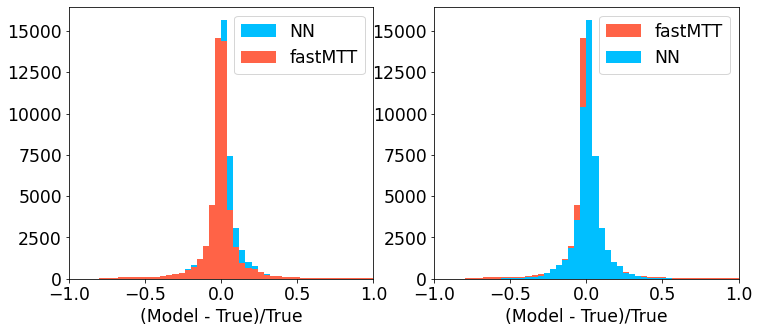

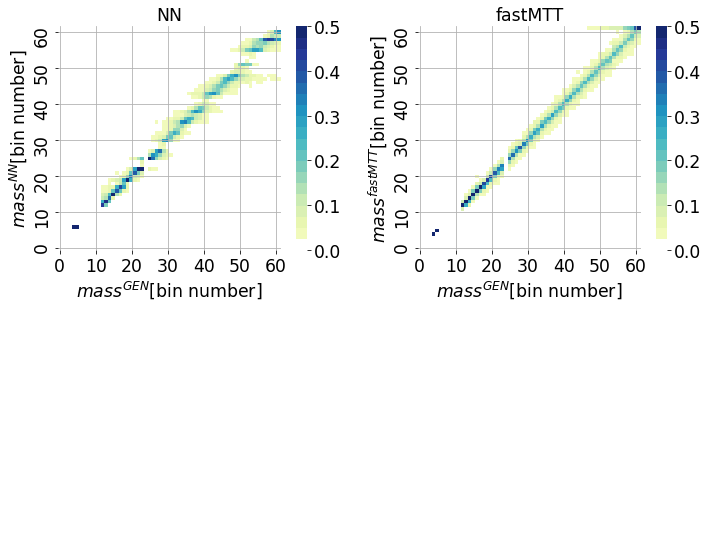

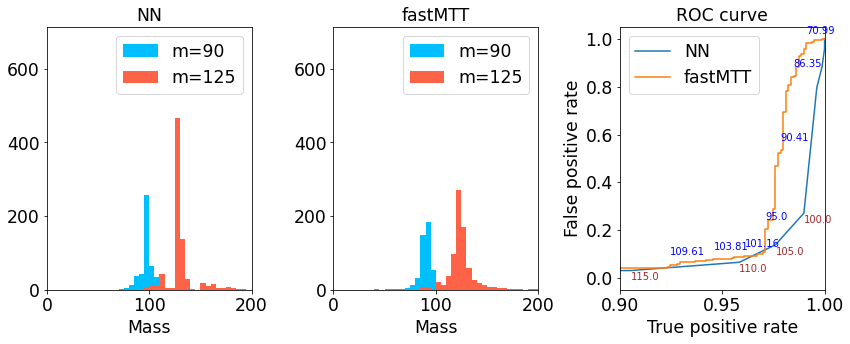

In [29]:
if not workOnPrometheus:
    nEpochsSaved = 250    
    checkpoint_path = "training/model_{epoch:04d}"
    model = tf.keras.models.load_model(checkpoint_path.format(epoch=nEpochsSaved), custom_objects=custom_objects)
       
    current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
    print("Current Time =", current_time)

    testFileNames = glob.glob(testDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip') 
    #testFileNames = glob.glob(testDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8_smearMET.gzip')
    #testFileNames = glob.glob(testDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_DY_ggH125.gzip')
    test_dataset = loadDataset(testFileNames, isTrain=False, nEpochs=1, batchSize=50000)
    for aBatch in test_dataset.take(1).as_numpy_iterator():            
            labels = aBatch[1]  
            fastMTTPredictions = aBatch[2] 
            features = aBatch[0]
            predictions = model.predict(features, use_multiprocessing=True) 
            plotPull(labels=labels, predictions=predictions, fastMTTPredictions=fastMTTPredictions)
            plotCM(labels=labels, predictions=predictions, fastMTTPredictions=fastMTTPredictions)
            compareDYandH125(labels=labels, predictions=predictions, fastMTTPredictions=fastMTTPredictions)

## Apply MET smearing

fastMTT:
Mass range: Z90 mean pull: 0.048 pull RMS: 0.173 RMS/90: 0.0019
Mass range: H125 mean pull: -0.044 pull RMS: 0.198 RMS/125: 0.0016
NN:
Mass range: Z90 mean pull: 1.507 pull RMS: 0.945 RMS/90: 0.0105
Mass range: H125 mean pull: 0.702 pull RMS: 0.686 RMS/125: 0.0055


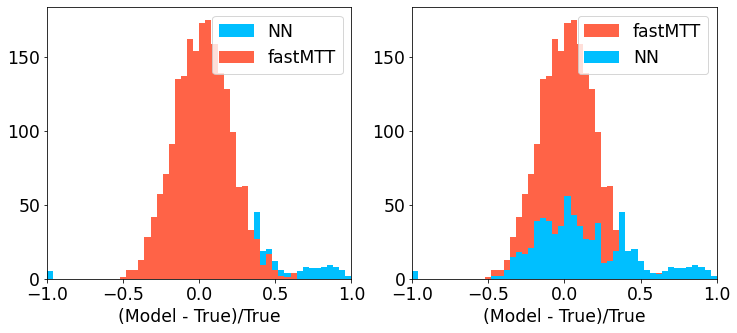

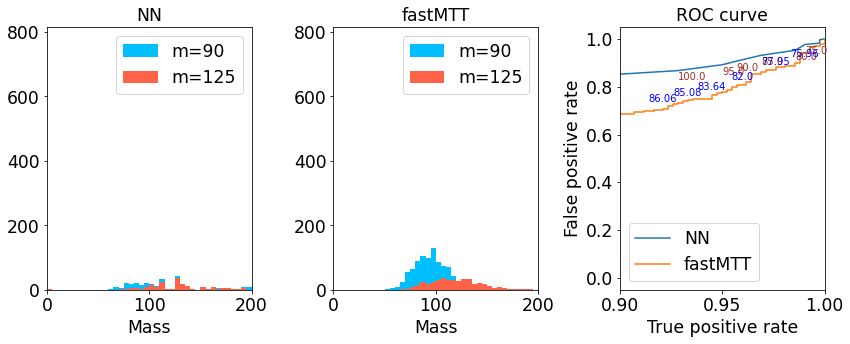

In [11]:
#testFileNames = glob.glob(testDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip') 
#testFileNames = glob.glob(testDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8_smearMET.gzip')
testFileNames = glob.glob(testDataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_DY_ggH125.gzip')
test_dataset = loadDataset(testFileNames, isTrain=False, nEpochs=1, batchSize=1)

generator = partial(smearedMETgenerator, test_dataset, 10)  
smeared_Dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))
     
nnMTT = np.zeros_like(massBins)
fastMTT = np.array([])
truth = np.array([])   

nEpochsSaved = 200
checkpoint_path = "training/model_{epoch:04d}"
model = tf.keras.models.load_model(checkpoint_path.format(epoch=nEpochsSaved), custom_objects=custom_objects)
    
for aBatch in smeared_Dataset.take(2000).as_numpy_iterator():
    labels = np.reshape(aBatch[1], [-1])
    fastMTTPredictions = np.reshape(aBatch[2], [-1])
    features = aBatch[0]
    original_met = np.reshape(aBatch[4:5], (2))
    smeared_met = np.reshape(features[:,-3:-1], (-1,2))
    predictions = model.predict(features, use_multiprocessing=True) 
    
    covariance = np.array(aBatch[3][0])
    covariance = np.reshape(covariance, (2,2)) 
    
    gauss2D = scipy.stats.multivariate_normal(mean=original_met, cov=covariance)
    met_tf_weights = gauss2D.pdf(smeared_met)
    met_tf_weights = tf.reshape(met_tf_weights, (-1,1))
    met_tf_weights = met_tf_weights/gauss2D.pdf(original_met)
    
    predictions_with_weights = tf.math.multiply(predictions, met_tf_weights)
    resultIndex = argmax_2d(predictions_with_weights)
    resultValue = label2Mass(resultIndex[1])
    
    nnMTT = np.vstack((nnMTT,predictions_with_weights[resultIndex[0]]))
    fastMTT = np.append(fastMTT, fastMTTPredictions[0])
    truth = np.append(truth, labels[0])
    
    '''
    print("label",labels[0])
    print("predictions.shape",predictions.shape)
    print("met_tf_weights.shape",met_tf_weights.shape)
    print("resultIndex",resultIndex)
    print("resultIndex[0]",resultIndex.numpy()[0])
    print("best weight",met_tf_weights[resultIndex.numpy()[0]])
    '''
    
    
    #plotMET(smeared_met, original_met, covariance)  
    #plotPull(labels=labels, predictions=predictions, fastMTTPredictions=fastMTTPredictions)
    #plotPull(labels=labels, predictions=predictions_with_weights, fastMTTPredictions=fastMTTPredictions)
    #plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[resultIndex.numpy()[0]]) 
    #plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[1]) 
    #plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[2]) 
    #plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[3]) 
    #plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[4]) 
    #plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[5]) 
    #plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[6])
    #plotPosterior(massGen = labels[0], labels=labels, predictions=predictions, indices=[8])
    #plotPull(labels=labels, predictions=predictions, fastMTTPredictions=fastMTTPredictions)
    #plotCM(labels=labels, predictions=predictions, fastMTTPredictions=fastMTTPredictions)
    #compareDYandH125(labels=labels, predictions=predictions, fastMTTPredictions=fastMTTPredictions)  
    
 
nnMTT = nnMTT[1:,:] 
plotPull(labels=truth, predictions=nnMTT, fastMTTPredictions=fastMTT)
compareDYandH125(labels=truth, predictions=nnMTT, fastMTTPredictions=fastMTT) 